<a href="https://colab.research.google.com/github/NguyenMaiPhuong311/ATI2/blob/main/tut8.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Sunspots


Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas.

They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection.

Sunspots usually appear in pairs of opposite magnetic polarity. The number of sunspots goes up and down as the Sun goes through its natural 11-year cycle. Scientists use sunspots to help them track this cycle.

The following graph shows the monthly mean sunspot number (blue) and 13-month smoothed monthly sunspot number (red) for the last five cycles.

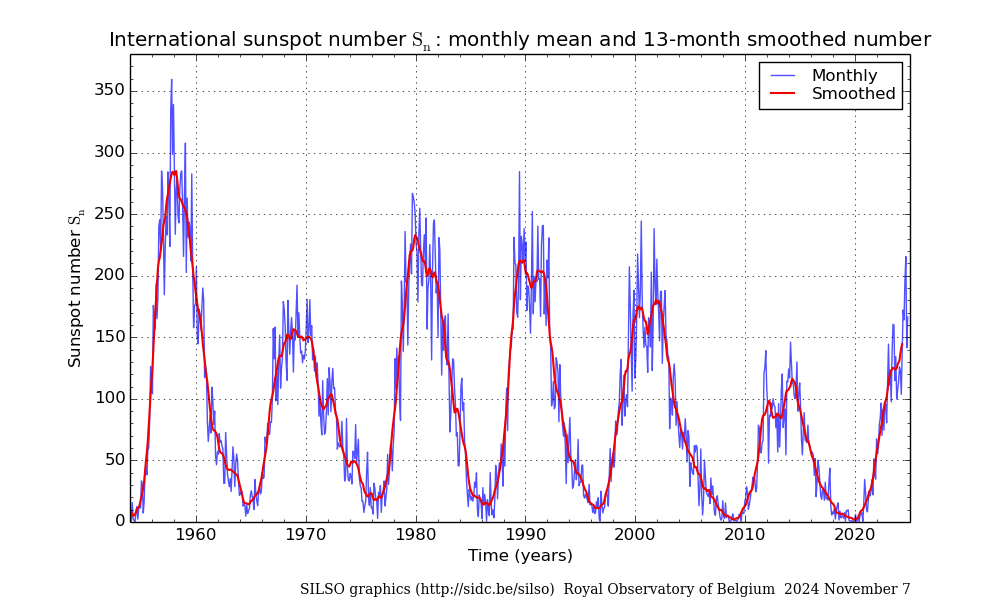

## Sunspots dataset


The sunspots dataset contains the monthly mean total sunspot number every years from 1749 to 2023.

The dataset could be downloaded from the following link:

[https://drive.google.com/file/d/1d8MiMRgDMb3Zp_F17RZ98HfaVUo0Qs7R/view?usp=sharing](https://drive.google.com/file/d/1d8MiMRgDMb3Zp_F17RZ98HfaVUo0Qs7R/view?usp=sharing)

## Sunspots number prediction

In this tutorial, we will create an RNN model for a regression task to predict the monthly total sunspot number based on the observed sunspots dataset.

We will proceed as follows:

1. Investigate and preprocess the dataset.

2. Create suitable input data for the RNN model.

3. Specify, compile, and fit the RNN model.

4. Make predictions on the training and test sets.

# Data preprocessing

## Load dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('sunspots.csv', sep=';')
data.head(20)

,Year,Month,Monthly Mean Total Sunspot Number
0,1749,1,96.7
1,1749,2,104.3
2,1749,3,116.7
3,1749,4,92.8
4,1749,5,141.7
5,1749,6,139.2
6,1749,7,158.0
7,1749,8,110.5
8,1749,9,126.5
9,1749,10,125.8


In [ ]:
data.shape

(3300, 3)

This section focuses on loading the sunspots dataset.

First, we import the necessary libraries: `numpy` for numerical operations, `pandas` for data manipulation, and `matplotlib.pyplot` for visualization.

Then, we load the dataset from the CSV file named `sunspots.csv` into a pandas DataFrame called `data`. We specify the separator as `;`.

Finally, we display the first few rows of the DataFrame using `data.head(20)` to get a glimpse of the data structure and content.

## Visualize the time series data

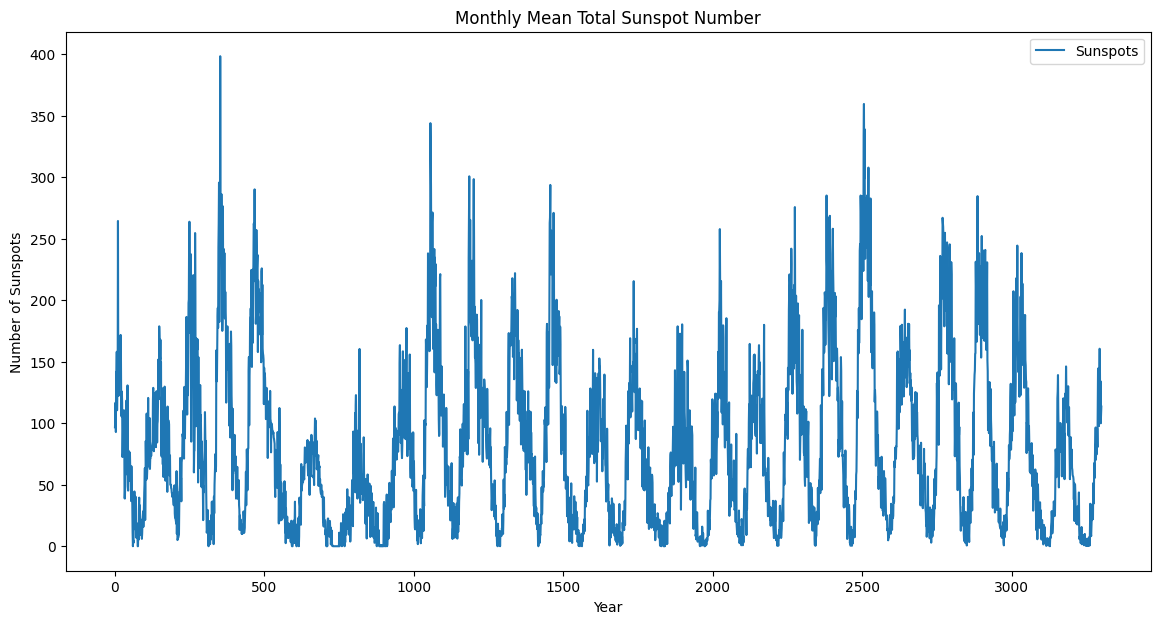

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['Monthly Mean Total Sunspot Number'], label='Sunspots')
plt.title('Monthly Mean Total Sunspot Number')
plt.xlabel('Year')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.grid(False)
plt.show()

This code block visualizes the sunspot data:

- `plt.figure(figsize=(14, 7))`: Creates a new figure for the plot with a specified size.
- `plt.plot(data['Monthly Mean Total Sunspot Number'], label='Sunspots')`: Plots the 'Monthly Mean Total Sunspot Number' column from the `data` DataFrame as a line graph and labels it 'Sunspots'.
- `plt.title('Monthly Mean Total Sunspot Number')`: Sets the title of the plot.
- `plt.xlabel('Year')`: Labels the x-axis as 'Year'.
- `plt.ylabel('Number of Sunspots')`: Labels the y-axis as 'Number of Sunspots'.
- `plt.legend()`: Displays the legend for the plot (showing the 'Sunspots' label).
- `plt.grid(False)`: Hides the grid lines on the plot.
- `plt.show()`: Displays the generated plot.

## Scaling the data between 0 and 1

We will use `MinMaxScaler` from scikit-learn to scale our data values between 0 and 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
series = data['Monthly Mean Total Sunspot Number'].to_numpy()
print(series)
series = scaler.fit_transform(series.reshape(-1, 1)).flatten()
print(series)

[ 96.7 104.3 116.7 ...  99.9 107.1 113.5]
[0.24284279 0.26192868 0.29306881 ... 0.25087896 0.26896032 0.28503265]


This code block scales the sunspot data:

- `from sklearn.preprocessing import MinMaxScaler`: Imports the `MinMaxScaler` from scikit-learn.
- `scaler = MinMaxScaler(feature_range=(0, 1))`: Creates a `MinMaxScaler` object to scale data between 0 and 1.
- `series = data['Monthly Mean Total Sunspot Number'].to_numpy()`: Extracts the 'Monthly Mean Total Sunspot Number' column as a NumPy array.
- `print(series)`: Prints the original NumPy array.
- `series = scaler.fit_transform(series.reshape(-1, 1)).flatten()`: Scales the data using the `MinMaxScaler`. `reshape(-1, 1)` is used to convert the 1D array to a 2D array as required by the scaler, and `.flatten()` converts it back to a 1D array after scaling.
- `print(series)`: Prints the scaled NumPy array.

Scaling the data is important for many machine learning models, including RNNs, as it helps to normalize the input values and can improve training performance and stability.

# Create input data

We will use the `sliding window ` approach to create input data sample to train our RNN model.

We will set the `window_size` to `12` for the sunspots dataset as the sunspots generally have a cycle of 12 months.

We take a window of a fixed size - 12 elements, and put that in the first row of our training data. From these 12 elements, we want to output the 13rd element, which is the label of the first sample. So we will set the `steps_ahead` to `1` to predict only one output element.

We keep sliding the window across, one element each time, to create a set of input samples and the corresponding labels that we can input into our RNN model.

In [ ]:
def create_dataset(series, window_size, steps_ahead):
    x = np.zeros((series.shape[0] - (window_size + steps_ahead - 1), window_size))
    y = np.zeros((series.shape[0] - (window_size + steps_ahead - 1), steps_ahead))

    for i in range(series.shape[0]):
        window = series[i : i + window_size + steps_ahead]
        if window.shape[0] < window_size + steps_ahead:
            break
        x[i], y[i] = window[:-steps_ahead], window[-steps_ahead:]

    return x, y

In [ ]:
window_size = 12
steps_ahead = 1
X, Y = create_dataset(series, window_size=window_size, steps_ahead=steps_ahead)

In [ ]:
print(X.shape, Y.shape)

for x, y in zip(X[:10], Y[:10]):
    print(f"{x} ----> {y}")

(3288, 12) (3288, 1)
[0.24284279 0.26192868 0.29306881 0.23304872 0.35585133 0.34957308
 0.39678553 0.27749874 0.31767956 0.31592165 0.66373682 0.35660472] ----> [0.30688096]
[0.26192868 0.29306881 0.23304872 0.35585133 0.34957308 0.39678553
 0.27749874 0.31767956 0.31592165 0.66373682 0.35660472 0.30688096] ----> [0.31767956]
[0.29306881 0.23304872 0.35585133 0.34957308 0.39678553 0.27749874
 0.31767956 0.31592165 0.66373682 0.35660472 0.30688096 0.31767956] ----> [0.37343044]
[0.23304872 0.35585133 0.34957308 0.39678553 0.27749874 0.31767956
 0.31592165 0.66373682 0.35660472 0.30688096 0.31767956 0.37343044] ----> [0.36966349]
[0.35585133 0.34957308 0.39678553 0.27749874 0.31767956 0.31592165
 0.66373682 0.35660472 0.30688096 0.31767956 0.37343044 0.36966349] ----> [0.37669513]
[0.34957308 0.39678553 0.27749874 0.31767956 0.31592165 0.66373682
 0.35660472 0.30688096 0.31767956 0.37343044 0.36966349 0.37669513] ----> [0.41863385]
[0.39678553 0.27749874 0.31767956 0.31592165 0.66373682

This section of the notebook focuses on creating the input data for the RNN model using the sliding window method.

- The `create_dataset` function takes the time series data, `window_size`, and `steps_ahead` as input.
- It initializes two NumPy arrays, `x` and `y`, to store the input sequences and corresponding labels, respectively. The shape of these arrays is calculated based on the length of the time series and the window parameters.
- It then iterates through the time series, creating a sliding window of size `window_size + steps_ahead` at each step.
- For each window, it extracts the first `window_size` elements as the input feature (`x`) and the last `steps_ahead` elements as the label (`y`).
- The loop continues until the window size is less than the required size.
- Finally, the function returns the `x` and `y` arrays.

- We set `window_size` to 12, representing the 12-month sunspot cycle, and `steps_ahead` to 1, as we want to predict the sunspot number for the next month.
- The `create_dataset` function is called with the scaled sunspot data (`series`), `window_size`, and `steps_ahead` to generate the input data `X` and labels `Y`.
- The shapes of `X` and `Y` are printed to show the number of samples and the dimensions of the input and output.
- The first 10 samples of `X` and their corresponding labels in `Y` are printed to illustrate how the sliding window creates input-output pairs. Each line shows an input sequence of 12 sunspot numbers followed by the predicted next sunspot number.

## Create training and testing set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2959, 12) (2959, 1)
(329, 12) (329, 1)


# Specify, compile and fit RNN model

## Create a simple RNN model

Our RNN model includes three simple RNN layers. Each RNN layer has 50 hidden units.

We want to to predict only one number as the output. Therefore, we add a dense layer perceptron at the end.

Because input and output values are in the range from 0 to 1, we will use `tanh` activation function.

We use `mean_squared_error` as the loss function, `adam` as the optimizer algorithm, and `mse` as the metrics when compiling the model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

def create_RNN(input_shape):
    model = Sequential()
    #Adding the first RNN layer
    model.add(SimpleRNN(50, input_shape=input_shape, activation='tanh', return_sequences=True))

    #Adding the second RNN layer
    model.add(SimpleRNN(50, activation='tanh', return_sequences=True))

    #Adding the third RNN layer
    model.add(SimpleRNN(50, activation='tanh'))

    model.add(Dense(units=1, activation='tanh'))
    return model


In [ ]:
model = create_RNN(input_shape=(window_size,1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 12, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, Y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0455 - mse: 0.0455
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0052 - mse: 0.0052
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0041 - mse: 0.0041
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0044 - mse: 0.0044
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0051 - mse: 0.0051
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - mse: 0.0041
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0043 - mse: 0.0043
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0047 - mse: 0.0047
Epoch 9/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0044 - mse: 0.0044
Epoch 10/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - mse: 0.0041
Epoch 11/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0045 - mse: 0.0045
Epoch 12/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041 - mse: 0.0041
Epoch 13/30
93/93 ━━━━━━━━━━━━━━━━━━━

This section focuses on building, compiling, and training the RNN model.

- We import necessary libraries from TensorFlow and Keras: `Sequential` for creating a linear stack of layers, `Dense` for fully connected layers, and `SimpleRNN` for the recurrent layers.
- The `create_RNN` function defines the model architecture:
    - It starts with a `Sequential` model.
    - It adds three `SimpleRNN` layers, each with 50 units and `tanh` activation. The first RNN layer requires `input_shape` to be specified. `return_sequences=True` is used in the first two RNN layers to return the full sequence of outputs for the next layer. The last RNN layer does not have `return_sequences=True` as it feeds into a dense layer.
    - A final `Dense` layer with 1 unit and `tanh` activation is added to output a single predicted value.
- The model is then compiled using `mean_squared_error` as the loss function (suitable for regression tasks), the `adam` optimizer, and `mse` as the metric to evaluate performance during training.
- `model.summary()` is used to display the model's architecture, including the number of parameters.
- Finally, `model.fit()` trains the model using the training data (`X_train`, `Y_train`) for 30 epochs with a batch size of 32. The `verbose=1` option shows the training progress.

## View the Result

In [ ]:
# Plot the result
def plot_result(Y_test, test_predict):
    # convert values back to original data
    actual = scaler.inverse_transform(Y_test)
    predictions = scaler.inverse_transform(test_predict)

    rows = len(actual)
    plt.figure(figsize=(14, 7))
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots numbers')
    plt.title('Actual and Predicted Values')

In [ ]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
print(test_predict[:10])

[[0.03721843]
 [0.14559433]
 [0.03550387]
 [0.28683612]
 [0.05921448]
 [0.15307449]
 [0.09431859]
 [0.53780156]
 [0.03096369]
 [0.0316098 ]]


In [ ]:
# Compute and Print the Root Mean Square Error
from sklearn.metrics import root_mean_squared_error

train_rmse = root_mean_squared_error(Y_train, train_predict)
print(f"Train RMSE: {train_rmse}")

test_rmse = root_mean_squared_error(Y_test, test_predict)
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.06126756462577236
Test RMSE: 0.06936861676981017


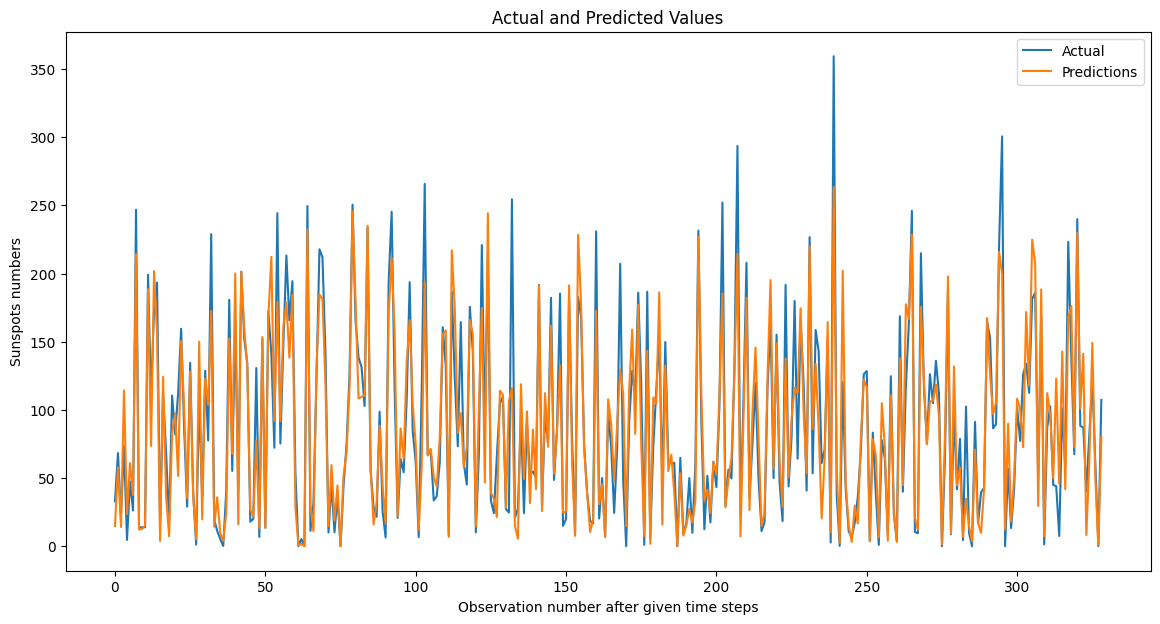

In [ ]:
plot_result(Y_test, test_predict)

This section focuses on evaluating the trained model and visualizing the results.

- The `plot_result` function is defined to visualize the actual vs. predicted values:
    - It takes the true test labels (`Y_test`) and the model's predictions on the test set (`test_predict`) as input.
    - It uses the `scaler` to inverse transform both the actual and predicted values back to their original scale.
    - It then plots the actual and predicted sunspot numbers over time, with labels and a title for clarity.
- The code then makes predictions on both the training and testing sets using `model.predict()`.
- It prints the first 10 predictions on the test set (`test_predict[:10]`).
- It calculates the Root Mean Squared Error (RMSE) for both the training and testing predictions using `root_mean_squared_error` from `sklearn.metrics`. RMSE is a common metric for regression tasks, indicating the average magnitude of the errors.
- Finally, it prints the calculated training and testing RMSE values and calls the `plot_result` function to display the visualization of the actual and predicted sunspot numbers on the test set.